# Strategy analysis example

Debugging a strategy can be time-consuming. Freqtrade offers helper functions to visualize raw data.
The following assumes you work with SampleStrategy, data for 5m timeframe from Binance and have downloaded them into the data directory in the default location.

## Setup

In [1]:
import os
from pathlib import Path

# Change directory
# Modify this cell to insure that the output shows the correct path.
# Define all paths relative to the project root shown in the cell output
project_root = "/freqtrade"
i=0
try:
    os.chdirdir(project_root)
    assert Path('LICENSE').is_file()
except:
    while i<4 and (not Path('LICENSE').is_file()):
        os.chdir(Path(Path.cwd(), '../'))
        i+=1
    project_root = Path.cwd()
print(Path.cwd())

/freqtrade


In [2]:
from pathlib import Path
from freqtrade.configuration import Configuration
from freqtrade.data.dataprovider import DataProvider
from freqtrade.resolvers import ExchangeResolver
from freqtrade.plugins.pairlistmanager import PairListManager

import nest_asyncio
nest_asyncio.apply()

# Customize these according to your needs.
configs=["test.json"]

# Initialize empty configuration object
config = Configuration.from_files(files=configs)
# Optionally, use existing configuration file
# config = Configuration.from_files(["config.json"])

# Define some constants
config["timeframe"] = "5m"
# Name of the strategy class
config["strategy"] = "NostalgiaForInfinityV4"
# Location of the data
data_location = Path(config['user_data_dir'], 'data', 'binance')

# Pair to analyze - Only use one pair here
pair = "TFUEL/USDT"

exchange = ExchangeResolver.load_exchange(config['exchange']['name'], config=config, validate=True)
pairlist = PairListManager(exchange, config)
dataprovider = DataProvider(config, exchange, pairlist)

In [3]:
# Load data using values set above
from freqtrade.data.history import load_pair_history

candles = load_pair_history(datadir=data_location,
                            timeframe=config["timeframe"],
                            pair=pair,
                            )

# Confirm success
print("Loaded " + str(len(candles)) + f" rows of data for {pair} from {data_location}")
candles.head()

Loaded 45194 rows of data for TFUEL/USDT from /freqtrade/user_data/data/binance


,date,open,high,low,close,volume
0,2021-01-01 00:00:00+00:00,0.033330,0.033330,0.032340,0.032500,3350088.0
1,2021-01-01 00:05:00+00:00,0.032500,0.032621,0.032013,0.032408,3429822.0
2,2021-01-01 00:10:00+00:00,0.032408,0.033068,0.032281,0.032950,3866771.0
3,2021-01-01 00:15:00+00:00,0.032828,0.033054,0.032300,0.032581,1858484.0
4,2021-01-01 00:20:00+00:00,0.032417,0.032560,0.031956,0.032118,2844781.0


## Load and run strategy
* Rerun each time the strategy file is changed

In [4]:
# Load strategy using values set above
from freqtrade.resolvers import StrategyResolver
strategy = StrategyResolver.load_strategy(config)
strategy.dp = dataprovider

# Generate buy/sell signals using strategy
df = strategy.analyze_ticker(candles, {'pair': pair})
df.tail()

,date,open,high,low,close,volume,date_1h,open_1h,high_1h,low_1h,...,smma_teeth,jaw,smma_jaw,rsi,safe_dips,safe_dips_strict,volume_mean_4,volume_mean_30,buy,sell
45189,2021-06-06 21:45:00+00:00,0.45643,0.45830,0.45447,0.45623,708344.2,2021-06-06 20:00:00+00:00,0.44555,0.45890,0.44472,...,0.459487,0.458207,0.455398,53.720667,True,True,1607604.250,9.408214e+05,NaN,NaN
45190,2021-06-06 21:50:00+00:00,0.45608,0.46850,0.45570,0.46850,1466753.0,2021-06-06 20:00:00+00:00,0.44555,0.45890,0.44472,...,0.460149,0.459510,0.456244,65.700965,True,True,848222.125,9.617770e+05,NaN,NaN
45191,2021-06-06 21:55:00+00:00,0.46805,0.46805,0.46248,0.46537,1463126.6,2021-06-06 21:00:00+00:00,0.45524,0.47168,0.45300,...,0.460780,0.460441,0.457177,61.338817,True,True,956665.925,9.880188e+05,NaN,NaN
45192,2021-06-06 22:00:00+00:00,0.46538,0.46999,0.46195,0.46645,1445914.6,2021-06-06 21:00:00+00:00,0.45524,0.47168,0.45300,...,0.461457,0.461303,0.458162,62.269675,True,True,1185755.650,1.011048e+06,NaN,NaN
45193,2021-06-06 22:05:00+00:00,0.46967,0.46995,0.45999,0.46037,727698.9,2021-06-06 21:00:00+00:00,0.45524,0.47168,0.45300,...,0.462025,0.461355,0.458977,54.337818,False,False,1271034.600,1.026726e+06,NaN,NaN


### Display the trade details

* Note that using `data.head()` would also work, however most indicators have some "startup" data at the top of the dataframe.
* Some possible problems
    * Columns with NaN values at the end of the dataframe
    * Columns used in `crossed*()` functions with completely different units
* Comparison with full backtest
    * having 200 buy signals as output for one pair from `analyze_ticker()` does not necessarily mean that 200 trades will be made during backtesting.
    * Assuming you use only one condition such as, `df['rsi'] < 30` as buy condition, this will generate multiple "buy" signals for each pair in sequence (until rsi returns > 29). The bot will only buy on the first of these signals (and also only if a trade-slot ("max_open_trades") is still available), or on one of the middle signals, as soon as a "slot" becomes available.  


In [5]:
# Report results
print(f"Generated {df['buy'].sum()} buy signals")
data = df.set_index('date', drop=False)
data.tail()

Generated 70.0 buy signals


,date,open,high,low,close,volume,date_1h,open_1h,high_1h,low_1h,...,smma_teeth,jaw,smma_jaw,rsi,safe_dips,safe_dips_strict,volume_mean_4,volume_mean_30,buy,sell
date,,,,,,,,,,,,,,,,,,,,,
2021-06-06 21:45:00+00:00,2021-06-06 21:45:00+00:00,0.45643,0.45830,0.45447,0.45623,708344.2,2021-06-06 20:00:00+00:00,0.44555,0.45890,0.44472,...,0.459487,0.458207,0.455398,53.720667,True,True,1607604.250,9.408214e+05,NaN,NaN
2021-06-06 21:50:00+00:00,2021-06-06 21:50:00+00:00,0.45608,0.46850,0.45570,0.46850,1466753.0,2021-06-06 20:00:00+00:00,0.44555,0.45890,0.44472,...,0.460149,0.459510,0.456244,65.700965,True,True,848222.125,9.617770e+05,NaN,NaN
2021-06-06 21:55:00+00:00,2021-06-06 21:55:00+00:00,0.46805,0.46805,0.46248,0.46537,1463126.6,2021-06-06 21:00:00+00:00,0.45524,0.47168,0.45300,...,0.460780,0.460441,0.457177,61.338817,True,True,956665.925,9.880188e+05,NaN,NaN
2021-06-06 22:00:00+00:00,2021-06-06 22:00:00+00:00,0.46538,0.46999,0.46195,0.46645,1445914.6,2021-06-06 21:00:00+00:00,0.45524,0.47168,0.45300,...,0.461457,0.461303,0.458162,62.269675,True,True,1185755.650,1.011048e+06,NaN,NaN
2021-06-06 22:05:00+00:00,2021-06-06 22:05:00+00:00,0.46967,0.46995,0.45999,0.46037,727698.9,2021-06-06 21:00:00+00:00,0.45524,0.47168,0.45300,...,0.462025,0.461355,0.458977,54.337818,False,False,1271034.600,1.026726e+06,NaN,NaN


## Load existing objects into a Jupyter notebook

The following cells assume that you have already generated data using the cli.  
They will allow you to drill deeper into your results, and perform analysis which otherwise would make the output very difficult to digest due to information overload.

### Load backtest results to pandas dataframe

Analyze a trades dataframe (also used below for plotting)

In [6]:
from freqtrade.data.btanalysis import load_backtest_data, load_backtest_stats

# if backtest_dir points to a directory, it'll automatically load the last backtest file.
backtest_dir = config["user_data_dir"] / "backtest_results"
# backtest_dir can also point to a specific file 
# backtest_dir = config["user_data_dir"] / "backtest_results/backtest-result-2020-07-01_20-04-22.json"

In [19]:
# You can get the full backtest statistics by using the following command.
# This contains all information used to generate the backtest result.
stats = load_backtest_stats(backtest_dir)

strategy = 'NostalgiaForInfinityV4'
# All statistics are available per strategy, so if `--strategy-list` was used during backtest, this will be reflected here as well.
# Example usages:
print(stats['strategy'][strategy]['results_per_pair'])
# Get pairlist used for this backtest
print(stats['strategy'][strategy]['pairlist'])
# Get market change (average change of all pairs from start to end of the backtest period)
print(stats['strategy'][strategy]['market_change'])
# Maximum drawdown ()
print(stats['strategy'][strategy]['max_drawdown'])
# Maximum drawdown start and end
print(stats['strategy'][strategy]['drawdown_start'])
print(stats['strategy'][strategy]['drawdown_end'])


# Get strategy comparison (only relevant if multiple strategies were compared)
print(stats['strategy_comparison'])


[{'key': 'TFUEL/USDT', 'trades': 6, 'profit_mean': 0.030544686666666664, 'profit_mean_pct': 3.0544686666666663, 'profit_sum': 0.18326812, 'profit_sum_pct': 18.33, 'profit_total_abs': 75.27866832, 'profit_total': 0.07527866831999999, 'profit_total_pct': 7.53, 'duration_avg': '0:33:00', 'wins': 6, 'draws': 0, 'losses': 0}, {'key': 'NMR/USDT', 'trades': 2, 'profit_mean': 0.077498875, 'profit_mean_pct': 7.7498875, 'profit_sum': 0.15499775, 'profit_sum_pct': 15.5, 'profit_total_abs': 56.04586685, 'profit_total': 0.056045866849999994, 'profit_total_pct': 5.6, 'duration_avg': '5:28:00', 'wins': 2, 'draws': 0, 'losses': 0}, {'key': 'SLP/USDT', 'trades': 5, 'profit_mean': 0.037331388, 'profit_mean_pct': 3.7331388, 'profit_sum': 0.18665694, 'profit_sum_pct': 18.67, 'profit_total_abs': 55.63989123999999, 'profit_total': 0.05563989123999999, 'profit_total_pct': 5.56, 'duration_avg': '3:37:00', 'wins': 4, 'draws': 0, 'losses': 1}, {'key': 'ONG/USDT', 'trades': 6, 'profit_mean': 0.031617495, 'profit

In [7]:
# Load backtested trades as dataframe
trades = load_backtest_data(backtest_dir)

# Show value-counts per pair
trades.groupby("pair")["sell_reason"].value_counts()

pair        sell_reason      
ADA/USDT    signal_profit_u_1    1
ALGO/USDT   sell_signal          1
ALICE/USDT  signal_profit_u_1    3
ATM/USDT    sell_signal          1
            signal_profit_u_1    1
ATOM/USDT   sell_signal          1
AXS/USDT    sell_signal          1
BAKE/USDT   signal_profit_u_1    3
            sell_signal          1
BAT/USDT    signal_profit_u_1    1
BTCST/USDT  signal_profit_u_1    1
CAKE/USDT   signal_profit_u_1    1
CELR/USDT   signal_profit_u_1    1
CHR/USDT    sell_signal          1
            signal_profit_u_1    1
CKB/USDT    sell_signal          1
CTSI/USDT   sell_signal          1
DENT/USDT   signal_profit_u_1    1
DGB/USDT    signal_profit_u_1    1
DOT/USDT    signal_profit_u_1    1
ENJ/USDT    signal_profit_3      1
ETC/USDT    signal_profit_u_2    1
FTM/USDT    signal_profit_u_1    2
KAVA/USDT   sell_signal          1
KSM/USDT    signal_profit_3      1
LUNA/USDT   signal_profit_u_1    2
MATIC/USDT  signal_profit_u_1    6
MKR/USDT    signal_profit

### Load live trading results into a pandas dataframe

In case you did already some trading and want to analyze your performance

In [ ]:
from freqtrade.data.btanalysis import load_trades_from_db

# Fetch trades from database
trades = load_trades_from_db("sqlite:///tradesv3.sqlite")

# Display results
trades.groupby("pair")["sell_reason"].value_counts()

## Analyze the loaded trades for trade parallelism
This can be useful to find the best `max_open_trades` parameter, when used with backtesting in conjunction with `--disable-max-market-positions`.

`analyze_trade_parallelism()` returns a timeseries dataframe with an "open_trades" column, specifying the number of open trades for each candle.

<AxesSubplot:xlabel='date'>

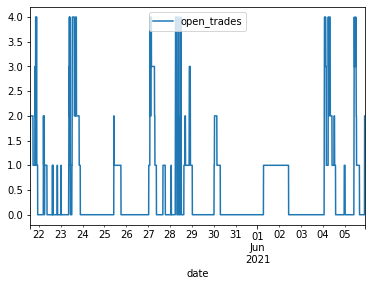

In [8]:
from freqtrade.data.btanalysis import analyze_trade_parallelism

# Analyze the above
parallel_trades = analyze_trade_parallelism(trades, '5m')

parallel_trades.plot()

## Plot results

Freqtrade offers interactive plotting capabilities based on plotly.

In [16]:
import plotly.offline as py
import plotly.graph_objs as go

py.init_notebook_mode(connected=True) # Initialise offline ploytly environment
from freqtrade.plot.plotting import  generate_candlestick_graph
# Limit graph period to keep plotly quick and reactive

# Filter trades to one pair
trades_red = trades.loc[trades['pair'] == pair]

data_red = data['2019-06-01':'2019-06-10']
# Generate candlestick graph
graph = generate_candlestick_graph(pair=pair,
                                   data=data_red,
                                   trades=trades_red,
                                   indicators1=['sma20', 'ema50', 'ema55'],
                                   indicators2=['rsi', 'macd', 'macdsignal', 'macdhist']
                                  )




In [17]:
# Show graph inline
graph.show()

## Plot average profit per trade as distribution graph

In [12]:
import plotly.figure_factory as ff

hist_data = [trades.profit_ratio]
group_labels = ['profit_ratio']  # name of the dataset

fig = ff.create_distplot(hist_data, group_labels,bin_size=0.01)
fig.show()


Feel free to submit an issue or Pull Request enhancing this document if you would like to share ideas on how to best analyze the data.